# Olivine Diffusion - 3
## Understanding Parameter Uncertainties with Bootstrap

*Course: Geochemical Modelling - Master 2*  
(c) Charles Le Losq

---

## Learning Objectives

By the end of this notebook, you should understand:

1. **Why traditional error estimates can be unreliable**
2. **What is the bootstrap method** and why it works
3. **How to implement a simple bootstrap** for parameter uncertainties
4. **How to visualize and interpret** bootstrap results
5. **How to report uncertainties** properly in geochemistry

---

## The Problem: Can We Trust Our Error Bars?

In Notebooks 1-2, we fitted diffusion profiles and obtained parameter uncertainties from the covariance matrix. 

**But these uncertainties have assumptions:**
- The model is approximately linear near the best fit
- Errors follow a normal (Gaussian) distribution  
- The fitting algorithm found the true global minimum

**If these assumptions are violated, we might:**
- Underestimate our uncertainties (too confident!)
- Miss important parameter correlations
- Report wrong conclusions

---

## The Solution: Bootstrap Method

**The core idea is simple:**

> "Your data is the best estimate of the population you'll ever have. So resample it!"

**How it works:**
1. Take your original dataset (e.g., 25 points)
2. Create a new dataset by randomly picking 25 points **with replacement**
   - Some points appear multiple times
   - Some points don't appear at all
3. Fit this new dataset → get new parameters
4. Repeat steps 2-3 many times (e.g., 1000 times)
5. Look at the distribution of all fitted parameters

**The distribution tells us the real uncertainty!**

**Advantages:**
- ✅ No assumptions about distributions
- ✅ Works with any fitting method
- ✅ Shows parameter correlations naturally
- ✅ Easy to understand and implement

---

## Notebook Structure

1. Load data and perform baseline fit (review from Notebooks 1-2)
2. Understand covariance-based uncertainties and their limits
3. Implement bootstrap resampling step-by-step
4. Visualize bootstrap results
5. Compare bootstrap vs covariance uncertainties
6. Report results properly

## Step 1: Setup and Data Loading

First, let's load our libraries and data. This is similar to Notebooks 1 and 2.

In [1]:
# Import necessary libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution
from scipy.special import erfc

# Set random seed for reproducibility
np.random.seed(42)

# Make plots look nice
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

Dataset loaded:
  Number of points: 67
  Distance range: 0.0 to 220.1 µm
  Concentration range: 46.7 to 183.5 ppm
  Average uncertainty: 5.0 ppm


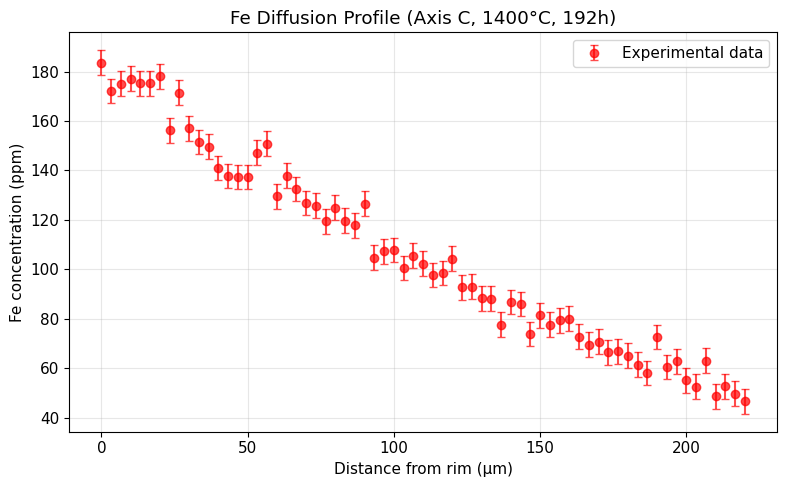

In [11]:
# Load experimental data (Axis C orientation)
data = pd.read_csv("./data/16C_ICP1_1400C_axisC_192h_FoEn.csv")

# Extract distance and Fe concentration
x_data = data['Distance'].values      # Distance from rim (micrometers)
y_data = data['Fe_ppm_m57'].values    # Fe concentration (ppm)

# Estimate measurement uncertainties
# Rule: 5 ppm
sigma_data = 5.0*np.ones_like(y_data)  # Placeholder for uncertainties

# Display dataset information
print(f"Dataset loaded:")
print(f"  Number of points: {len(x_data)}")
print(f"  Distance range: {x_data.min():.1f} to {x_data.max():.1f} µm")
print(f"  Concentration range: {y_data.min():.1f} to {y_data.max():.1f} ppm")
print(f"  Average uncertainty: {sigma_data.mean():.1f} ppm")

# Quick visualization
plt.figure(figsize=(8, 5))
plt.errorbar(x_data, y_data, yerr=sigma_data, 
             fmt='o', color='red', capsize=3, 
             label='Experimental data', alpha=0.7)
plt.xlabel('Distance from rim (µm)')
plt.ylabel('Fe concentration (ppm)')
plt.title('Fe Diffusion Profile (Axis C, 1400°C, 192h)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 2: Define the Diffusion Model

We use the same 1D diffusion model from previous notebooks:

$$c(x,t) = (c_{rim} - c_{bg}) \times \text{erfc}\left(\frac{x}{2\sqrt{Dt}}\right) + c_{bg}$$

**Parameters to fit:**
- `D`: diffusion coefficient (in log₁₀ m²/s)
- `c_rim`: concentration at the rim (ppm)
- `c_bg`: background concentration (ppm)

In [12]:
def forward_model(x, D, c_rim, c_bg):
    """
    1D diffusion model
    
    Parameters:
    -----------
    x : array
        Distance from rim in micrometers
    D : float
        Diffusion coefficient in log10(m²/s)
    c_rim : float
        Rim concentration in ppm
    c_bg : float
        Background concentration in ppm
        
    Returns:
    --------
    concentration : array
        Predicted concentration profile
    """
    # Convert time to seconds (192 hours)
    time_seconds = 192.0 * 3600
    
    # Convert distance to meters
    x_meters = x * 1e-6
    
    # Convert D from log to linear
    D_linear = 10**D
    
    # Calculate concentration profile
    concentration = (c_rim - c_bg) * erfc(x_meters / (2 * np.sqrt(D_linear * time_seconds))) + c_bg
    
    return concentration

print("✓ Diffusion model defined")

✓ Diffusion model defined


## Step 3: Baseline Fit with Covariance Uncertainties

Let's fit our data the traditional way and get uncertainties from the covariance matrix.

We'll use a two-step approach:
1. **Global search** with differential evolution (finds approximate solution)
2. **Local refinement** with curve_fit (gets precise fit + covariance matrix)

In [13]:
# Step 1: Global optimization to find the best starting point
print("Running global optimization...")

# Define objective function for global search
def objective_function(params, x, y, sigma):
    """Calculate weighted sum of squared residuals"""
    D, c_rim, c_bg = params
    model = forward_model(x, D, c_rim, c_bg)
    residuals = (y - model) / sigma
    return np.sum(residuals**2)

# Define search bounds (physically reasonable values)
bounds = [
    [-18.0, -10.0],  # D: typical range for trace elements in olivine
    [0.0, 200.0],    # c_rim: positive, reasonable upper bound
    [0.0, 50.0]      # c_bg: background lower than rim
]

# Run global search
result = differential_evolution(
    objective_function,
    bounds,
    args=(x_data, y_data, sigma_data),
    seed=42,
    maxiter=200
)

# Get initial guess from global search
p_initial = result.x
print(f"Global search complete!")
print(f"  Initial D = {p_initial[0]:.3f}")
print(f"  Initial c_rim = {p_initial[1]:.1f} ppm")
print(f"  Initial c_bg = {p_initial[2]:.1f} ppm")

Running global optimization...
Global search complete!
  Initial D = -13.725
  Initial c_rim = 181.7 ppm
  Initial c_bg = 23.3 ppm


In [14]:
# Step 2: Local refinement with curve_fit to get covariance
print("\nRefining fit and calculating covariance...")

# Fit with curve_fit (this gives us the covariance matrix)
popt, pcov = curve_fit(
    forward_model,
    x_data, y_data,
    p0=p_initial,           # Start from global optimum
    sigma=sigma_data,       # Measurement uncertainties
    absolute_sigma=True,    # Use actual sigma values
    maxfev=2000
)

# Extract uncertainties from covariance diagonal
# The diagonal elements are the variances, so we take the square root
param_uncertainties = np.sqrt(np.diag(pcov))

# Display results
print("\n=== BASELINE FIT RESULTS (Covariance Method) ===")
print(f"D = {popt[0]:.4f} ± {param_uncertainties[0]:.4f} log₁₀(m²/s)")
print(f"c_rim = {popt[1]:.2f} ± {param_uncertainties[1]:.2f} ppm")
print(f"c_bg = {popt[2]:.2f} ± {param_uncertainties[2]:.2f} ppm")

# Calculate model predictions
y_fit = forward_model(x_data, *popt)

# Calculate fit quality
residuals = y_data - y_fit
chi_squared = np.sum((residuals / sigma_data)**2)
n_params = 3
reduced_chi_squared = chi_squared / (len(x_data) - n_params)

print(f"\nFit quality:")
print(f"  χ² = {chi_squared:.2f}")
print(f"  Reduced χ² = {reduced_chi_squared:.2f}")
if 0.5 < reduced_chi_squared < 2.0:
    print(f"  ✓ Good fit quality")
else:
    print(f"  ⚠ Fit quality may be problematic")

# Store baseline results for later comparison
baseline_params = popt.copy()
baseline_uncertainties = param_uncertainties.copy()


Refining fit and calculating covariance...

=== BASELINE FIT RESULTS (Covariance Method) ===
D = -13.7246 ± 0.0638 log₁₀(m²/s)
c_rim = 181.65 ± 1.70 ppm
c_bg = 23.34 ± 7.61 ppm

Fit quality:
  χ² = 75.97
  Reduced χ² = 1.19
  ✓ Good fit quality


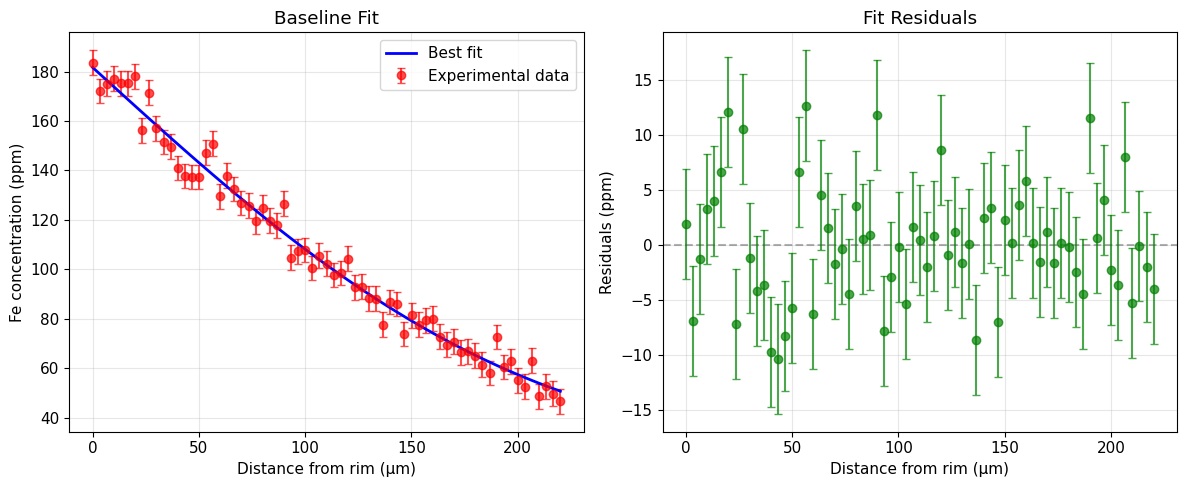


Residual statistics:
  Mean residual: -0.00 ppm
  Std residual: 5.32 ppm
  Max absolute residual: 12.65 ppm


In [15]:
# Visualize the fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left panel: Data and fit
ax1.errorbar(x_data, y_data, yerr=sigma_data,
             fmt='o', color='red', capsize=3,
             label='Experimental data', alpha=0.7)
ax1.plot(x_data, y_fit, 'b-', linewidth=2, label='Best fit')
ax1.set_xlabel('Distance from rim (µm)')
ax1.set_ylabel('Fe concentration (ppm)')
ax1.set_title('Baseline Fit')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right panel: Residuals
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.errorbar(x_data, residuals, yerr=sigma_data,
             fmt='o', color='green', capsize=3, alpha=0.7)
ax2.set_xlabel('Distance from rim (µm)')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_title('Fit Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual statistics:")
print(f"  Mean residual: {np.mean(residuals):.2f} ppm")
print(f"  Std residual: {np.std(residuals):.2f} ppm")
print(f"  Max absolute residual: {np.max(np.abs(residuals)):.2f} ppm")

## Step 4: Understanding the Bootstrap Method

Now let's implement the bootstrap! We'll break it down into simple steps.

### What we'll do:

1. **Create one bootstrap sample** by randomly selecting data points with replacement
2. **Fit this new dataset** to get new parameters  
3. **Repeat many times** (e.g., 1000 times)
4. **Analyze the distribution** of all bootstrap parameters

Let's start with a single bootstrap iteration to understand the process.

In [16]:
# Example: Create ONE bootstrap sample
print("Creating one bootstrap sample...\n")

# Number of data points
n_points = len(x_data)
print(f"Original dataset has {n_points} points")

# Randomly select indices WITH replacement
# This means some points will appear multiple times, others not at all
bootstrap_indices = np.random.choice(n_points, size=n_points, replace=True)

print(f"\nExample bootstrap indices (first 10): {bootstrap_indices[:10]}")
print(f"Notice: some numbers appear multiple times!")

# Create bootstrap dataset using these indices
x_boot = x_data[bootstrap_indices]
y_boot = y_data[bootstrap_indices]
sigma_boot = sigma_data[bootstrap_indices]

# How many unique points?
unique_points = len(np.unique(bootstrap_indices))
print(f"\nThis bootstrap sample contains {unique_points} unique points (out of {n_points})")
print(f"Some points are repeated, some are missing - that's normal!")

# Fit this bootstrap sample
popt_boot, _ = curve_fit(
    forward_model,
    x_boot, y_boot,
    p0=baseline_params,  # Start from our baseline fit
    sigma=sigma_boot,
    absolute_sigma=True,
    maxfev=1000
)

print(f"\n=== Bootstrap sample #1 results ===")
print(f"D = {popt_boot[0]:.4f} (baseline: {baseline_params[0]:.4f})")
print(f"c_rim = {popt_boot[1]:.2f} (baseline: {baseline_params[1]:.2f})")
print(f"c_bg = {popt_boot[2]:.2f} (baseline: {baseline_params[2]:.2f})")
print(f"\nNotice: parameters are slightly different from baseline!")
print(f"This is because we're fitting a slightly different dataset.")

Creating one bootstrap sample...

Original dataset has 67 points

Example bootstrap indices (first 10): [51 14 60 20 23  2 21 52  1 29]
Notice: some numbers appear multiple times!

This bootstrap sample contains 39 unique points (out of 67)
Some points are repeated, some are missing - that's normal!

=== Bootstrap sample #1 results ===
D = -13.7314 (baseline: -13.7246)
c_rim = 182.48 (baseline: 181.65)
c_bg = 22.23 (baseline: 23.34)

Notice: parameters are slightly different from baseline!
This is because we're fitting a slightly different dataset.


## Step 5: Full Bootstrap Implementation

Now we'll repeat the bootstrap process many times (typically 500-1000 times).

**Note:** This will take a minute or two to run. We'll show progress updates.

In [17]:
# Bootstrap settings
n_bootstrap = 500  # Number of bootstrap samples
                   # (1000 is better but takes longer)

print(f"Running {n_bootstrap} bootstrap iterations...")
print("This may take 1-2 minutes. Please wait...\n")

# Arrays to store bootstrap results
bootstrap_D = []       # Diffusion coefficients
bootstrap_c_rim = []   # Rim concentrations  
bootstrap_c_bg = []    # Background concentrations

# Counter for successful fits
n_success = 0

# Run bootstrap iterations
for i in range(n_bootstrap):
    # Show progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"  Progress: {i+1}/{n_bootstrap} ({(i+1)/n_bootstrap*100:.0f}%)")
    
    try:
        # Create bootstrap sample (with replacement)
        boot_indices = np.random.choice(n_points, size=n_points, replace=True)
        x_boot = x_data[boot_indices]
        y_boot = y_data[boot_indices]
        sigma_boot = sigma_data[boot_indices]
        
        # Fit bootstrap sample
        popt_boot, _ = curve_fit(
            forward_model,
            x_boot, y_boot,
            p0=baseline_params,
            sigma=sigma_boot,
            absolute_sigma=True,
            maxfev=1000
        )
        
        # Store results
        bootstrap_D.append(popt_boot[0])
        bootstrap_c_rim.append(popt_boot[1])
        bootstrap_c_bg.append(popt_boot[2])
        
        n_success += 1
        
    except:
        # If fitting fails, skip this iteration
        # (This can happen occasionally with bad bootstrap samples)
        pass

# Convert to arrays for easier analysis
bootstrap_D = np.array(bootstrap_D)
bootstrap_c_rim = np.array(bootstrap_c_rim)
bootstrap_c_bg = np.array(bootstrap_c_bg)

print(f"\n=== Bootstrap Complete ===")
print(f"Successful fits: {n_success}/{n_bootstrap} ({n_success/n_bootstrap*100:.1f}%)")

if n_success < 0.9 * n_bootstrap:
    print(f"⚠ Warning: Some bootstrap samples failed to fit")
    print(f"  This is usually OK if success rate > 80%")
else:
    print(f"✓ Excellent success rate!")

Running 500 bootstrap iterations...
This may take 1-2 minutes. Please wait...

  Progress: 100/500 (20%)
  Progress: 200/500 (40%)
  Progress: 300/500 (60%)
  Progress: 400/500 (80%)
  Progress: 500/500 (100%)

=== Bootstrap Complete ===
Successful fits: 500/500 (100.0%)
✓ Excellent success rate!


## Step 6: Analyze Bootstrap Results

Now let's look at what the bootstrap tells us about parameter uncertainties!

In [18]:
# Calculate bootstrap statistics
print("=== BOOTSTRAP UNCERTAINTY ESTIMATES ===")
print()

# For each parameter, calculate mean and standard deviation
# The standard deviation of the bootstrap distribution IS the uncertainty!

# D parameter
D_mean = np.mean(bootstrap_D)
D_std = np.std(bootstrap_D, ddof=1)  # ddof=1 for sample std
D_median = np.median(bootstrap_D)

print(f"D (log₁₀ m²/s):")
print(f"  Mean ± Std: {D_mean:.4f} ± {D_std:.4f}")
print(f"  Median: {D_median:.4f}")
print(f"  95% CI: [{np.percentile(bootstrap_D, 2.5):.4f}, {np.percentile(bootstrap_D, 97.5):.4f}]")
print()

# c_rim parameter
c_rim_mean = np.mean(bootstrap_c_rim)
c_rim_std = np.std(bootstrap_c_rim, ddof=1)
c_rim_median = np.median(bootstrap_c_rim)

print(f"c_rim (ppm):")
print(f"  Mean ± Std: {c_rim_mean:.2f} ± {c_rim_std:.2f}")
print(f"  Median: {c_rim_median:.2f}")
print(f"  95% CI: [{np.percentile(bootstrap_c_rim, 2.5):.2f}, {np.percentile(bootstrap_c_rim, 97.5):.2f}]")
print()

# c_bg parameter
c_bg_mean = np.mean(bootstrap_c_bg)
c_bg_std = np.std(bootstrap_c_bg, ddof=1)
c_bg_median = np.median(bootstrap_c_bg)

print(f"c_bg (ppm):")
print(f"  Mean ± Std: {c_bg_mean:.2f} ± {c_bg_std:.2f}")
print(f"  Median: {c_bg_median:.2f}")
print(f"  95% CI: [{np.percentile(bootstrap_c_bg, 2.5):.2f}, {np.percentile(bootstrap_c_bg, 97.5):.2f}]")
print()

# Store bootstrap uncertainties
bootstrap_uncertainties = np.array([D_std, c_rim_std, c_bg_std])

=== BOOTSTRAP UNCERTAINTY ESTIMATES ===

D (log₁₀ m²/s):
  Mean ± Std: -13.7264 ± 0.0673
  Median: -13.7238
  95% CI: [-13.8564, -13.5916]

c_rim (ppm):
  Mean ± Std: 181.70 ± 2.19
  Median: 181.66
  95% CI: [177.46, 186.21]

c_bg (ppm):
  Mean ± Std: 23.17 ± 8.00
  Median: 23.40
  95% CI: [6.04, 37.90]



## Step 7: Visualize Bootstrap Distributions

Let's see what the bootstrap distributions look like!

**Important:** If the distribution is:
- **Symmetric and bell-shaped** → covariance uncertainties are probably OK
- **Skewed or irregular** → covariance uncertainties may be wrong!

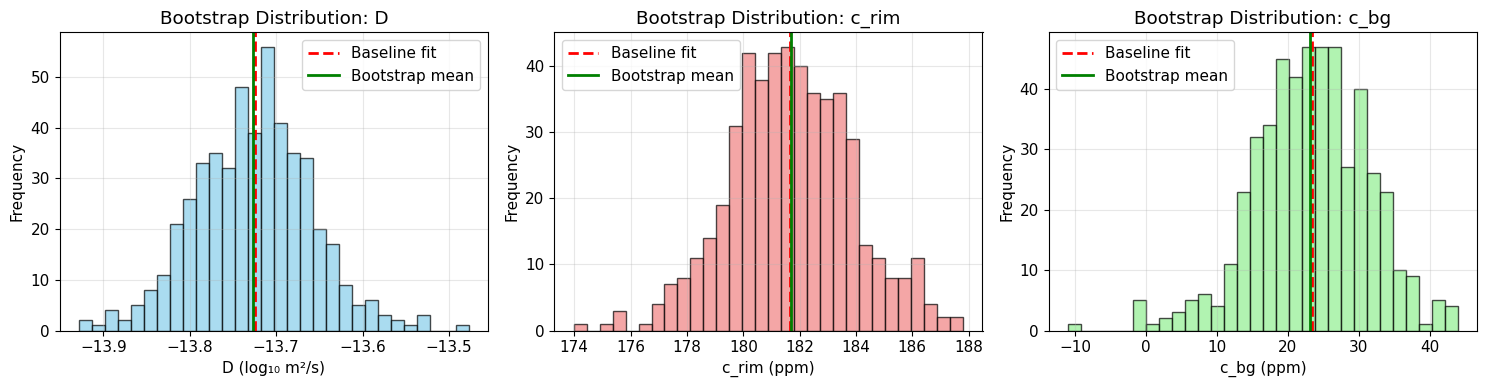


What to look for:
  ✓ Distributions should be roughly bell-shaped
  ✓ Baseline fit (red line) should be near the center
  ✓ No extreme outliers or multi-modal distributions
  ⚠ Skewed distributions suggest non-Gaussian uncertainties


In [19]:
# Create figure with three histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# D distribution
axes[0].hist(bootstrap_D, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(baseline_params[0], color='red', linestyle='--', 
                linewidth=2, label='Baseline fit')
axes[0].axvline(D_mean, color='green', linestyle='-', 
                linewidth=2, label='Bootstrap mean')
axes[0].set_xlabel('D (log₁₀ m²/s)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Bootstrap Distribution: D')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# c_rim distribution
axes[1].hist(bootstrap_c_rim, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(baseline_params[1], color='red', linestyle='--', 
                linewidth=2, label='Baseline fit')
axes[1].axvline(c_rim_mean, color='green', linestyle='-', 
                linewidth=2, label='Bootstrap mean')
axes[1].set_xlabel('c_rim (ppm)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Bootstrap Distribution: c_rim')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# c_bg distribution
axes[2].hist(bootstrap_c_bg, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].axvline(baseline_params[2], color='red', linestyle='--', 
                linewidth=2, label='Baseline fit')
axes[2].axvline(c_bg_mean, color='green', linestyle='-', 
                linewidth=2, label='Bootstrap mean')
axes[2].set_xlabel('c_bg (ppm)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Bootstrap Distribution: c_bg')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nWhat to look for:")
print("  ✓ Distributions should be roughly bell-shaped")
print("  ✓ Baseline fit (red line) should be near the center")
print("  ✓ No extreme outliers or multi-modal distributions")
print("  ⚠ Skewed distributions suggest non-Gaussian uncertainties")

## Step 8: Compare Bootstrap vs Covariance Uncertainties

This is the key comparison! Are the covariance-based uncertainties reliable?

In [20]:
# Create comparison table
print("=== UNCERTAINTY COMPARISON ===")
print()
print(f"{'Parameter':<12} {'Covariance':<20} {'Bootstrap':<20} {'Ratio':<10}")
print(f"{'-'*12} {'-'*20} {'-'*20} {'-'*10}")

param_names = ['D', 'c_rim', 'c_bg']
for i, name in enumerate(param_names):
    cov_unc = baseline_uncertainties[i]
    boot_unc = bootstrap_uncertainties[i]
    ratio = boot_unc / cov_unc
    
    print(f"{name:<12} {cov_unc:<20.4f} {boot_unc:<20.4f} {ratio:<10.2f}")

print()
print("Interpretation of Ratio (Bootstrap/Covariance):")
print("  ~1.0: Covariance uncertainties are reliable")
print("  >1.5: Covariance underestimates uncertainties (too optimistic!)")
print("  <0.7: Covariance overestimates uncertainties (too conservative)")
print()

# Calculate average ratio
avg_ratio = np.mean(bootstrap_uncertainties / baseline_uncertainties)
print(f"Average ratio: {avg_ratio:.2f}")

if 0.8 <= avg_ratio <= 1.2:
    print("✓ Covariance uncertainties are reasonable")
elif avg_ratio > 1.2:
    print(f"⚠ Bootstrap uncertainties are {avg_ratio:.1f}x larger!")
    print("  → Covariance method is too optimistic")
    print("  → Use bootstrap uncertainties for publication")
else:
    print("⚠ Bootstrap uncertainties are smaller")
    print("  → This is unusual, check your data/fitting")

=== UNCERTAINTY COMPARISON ===

Parameter    Covariance           Bootstrap            Ratio     
------------ -------------------- -------------------- ----------
D            0.0638               0.0673               1.05      
c_rim        1.6952               2.1891               1.29      
c_bg         7.6069               8.0026               1.05      

Interpretation of Ratio (Bootstrap/Covariance):
  ~1.0: Covariance uncertainties are reliable
  >1.5: Covariance underestimates uncertainties (too optimistic!)
  <0.7: Covariance overestimates uncertainties (too conservative)

Average ratio: 1.13
✓ Covariance uncertainties are reasonable


## Step 9: Visualize Parameter Correlations

Bootstrap also shows us how parameters are correlated.

**Why this matters:**
- If D and c_rim are strongly correlated, you can't determine them independently
- This affects experimental design and interpretation

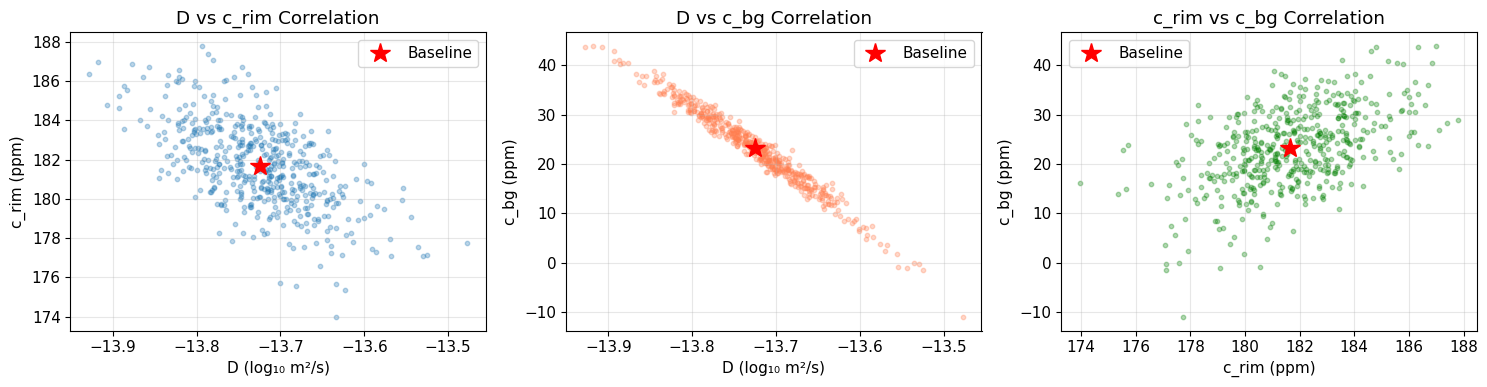


Parameter Correlations:
  D vs c_rim: -0.613
  D vs c_bg: -0.985
  c_rim vs c_bg: +0.509

Interpretation:
  Near 0: No correlation (independent)
  Near +1: Strong positive correlation
  Near -1: Strong negative correlation


In [21]:
# Create scatter plots showing parameter correlations
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# D vs c_rim
axes[0].scatter(bootstrap_D, bootstrap_c_rim, alpha=0.3, s=10)
axes[0].plot(baseline_params[0], baseline_params[1], 'r*', 
             markersize=15, label='Baseline')
axes[0].set_xlabel('D (log₁₀ m²/s)')
axes[0].set_ylabel('c_rim (ppm)')
axes[0].set_title('D vs c_rim Correlation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# D vs c_bg
axes[1].scatter(bootstrap_D, bootstrap_c_bg, alpha=0.3, s=10, color='coral')
axes[1].plot(baseline_params[0], baseline_params[2], 'r*', 
             markersize=15, label='Baseline')
axes[1].set_xlabel('D (log₁₀ m²/s)')
axes[1].set_ylabel('c_bg (ppm)')
axes[1].set_title('D vs c_bg Correlation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# c_rim vs c_bg
axes[2].scatter(bootstrap_c_rim, bootstrap_c_bg, alpha=0.3, s=10, color='green')
axes[2].plot(baseline_params[1], baseline_params[2], 'r*', 
             markersize=15, label='Baseline')
axes[2].set_xlabel('c_rim (ppm)')
axes[2].set_ylabel('c_bg (ppm)')
axes[2].set_title('c_rim vs c_bg Correlation')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation coefficients
print("\nParameter Correlations:")
corr_D_crim = np.corrcoef(bootstrap_D, bootstrap_c_rim)[0, 1]
corr_D_cbg = np.corrcoef(bootstrap_D, bootstrap_c_bg)[0, 1]
corr_crim_cbg = np.corrcoef(bootstrap_c_rim, bootstrap_c_bg)[0, 1]

print(f"  D vs c_rim: {corr_D_crim:+.3f}")
print(f"  D vs c_bg: {corr_D_cbg:+.3f}")
print(f"  c_rim vs c_bg: {corr_crim_cbg:+.3f}")
print()
print("Interpretation:")
print("  Near 0: No correlation (independent)")
print("  Near +1: Strong positive correlation")
print("  Near -1: Strong negative correlation")

## Summary and Key Takeaways

### What We Learned:

1. **Bootstrap is a powerful, assumption-free method** for uncertainty quantification
   - No need to assume Gaussian distributions
   - Works with any fitting algorithm
   - Shows real uncertainty in your data

2. **Covariance uncertainties can be misleading**
   - Often underestimate true uncertainties
   - Assume linear model behavior
   - Miss non-Gaussian distributions

3. **Bootstrap reveals parameter correlations**
   - Some parameters may be difficult to determine independently
   - Important for experimental design

4. **The method is conceptually simple**
   - Resample your data with replacement
   - Fit each resampled dataset
   - Analyze the distribution of fitted parameters

### Best Practices for Reporting Results:

When publishing geochemical data:

✅ **DO:**
- Report bootstrap uncertainties when possible
- State the number of bootstrap iterations used
- Show parameter distributions if they're non-Gaussian
- Report confidence intervals (e.g., 95% CI)
- Discuss parameter correlations if significant

❌ **DON'T:**
- Rely only on covariance uncertainties for complex models
- Ignore skewed or multi-modal distributions
- Report uncertainties to unrealistic precision
- Forget to state your uncertainty method

### Further Reading:

- Efron & Tibshirani (1994): "An Introduction to the Bootstrap" - Classic reference
- Davidson & Hinkley (1997): "Bootstrap Methods and their Application"

---

## Exercise:

Try modifying the code to:

1. **Change the number of bootstrap iterations**
   - Try n=100, 500, 1000
   - How does this affect the uncertainty estimates?
   
2. **Use different crystallographic orientations**
   - Load the Axis A data instead of Axis C
   - Compare the uncertainties
   
3. **Investigate other elements**
   - The dataset contains Mg, Co, Mn, Ni
   - Which elements have the largest uncertainties?
   
4. **Test with smaller datasets**
   - Use only every 2nd or 3rd data point
   - How do uncertainties change with fewer points?

---

**End of Notebook 3**